## 1. Install Environment

In [ ]:
!pip install timm
!pip install torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 27.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install scikit-learn matplotlib


In [ ]:
!unrar x /content/cell_images.rar /content/cell_images/

ストリーミング出力は最後の 5000 行に切り捨てられました。
Extracting  /content/cell_images/cell_images/cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_245.png      83%  OK 
Extracting  /content/cell_images/cell_images/cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_251.png      83%  OK 
Extracting  /content/cell_images/cell_images/cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_261.png      83%  OK 
Extracting  /content/cell_images/cell_images/cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_41.png      83%  OK 
Extracting  /content/cell_images/cell_images/cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_54.png      83%  OK 
Extracting  /content/cell_images/cell_images/cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_57.png      83%  OK 
Extracting  /content/cell_images/cell_images/cell_images/train/uninfected/C228ThinF_IMG_20151112_142452_cell_85.png      83%

## 2. Data Preprocessing

In [ ]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from typing import Dict

def check_corrupted_images(folder_path: str) -> int:
    """
    Checks and removes corrupted images.

    Args:
        folder_path (str): The path to the folder containing class subfolders.

    Returns:
        int: Number of corrupted images removed.
    """
    removed = 0
    image_extensions = (".jpg", ".jpeg", ".png", ".bmp")
    for cls in os.listdir(folder_path):
        cls_path = os.path.join(folder_path, cls)
        if not os.path.isdir(cls_path):
            continue
        for img_name in os.listdir(cls_path):
            if not img_name.lower().endswith(image_extensions):
                continue
            img_path = os.path.join(cls_path, img_name)
            try:
                img = Image.open(img_path)
                img.verify()
            except Exception:
                os.remove(img_path)
                removed += 1
    return removed


# Setup paths (modify to match Google Drive mount path)
data_dir = "/content/cell_images/cell_images/cell_images/"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Image preprocessing
IMG_SIZE = 224
BATCH_SIZE = 32

transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

## 3. Model Definition (ViT Fine-tuning with timm)

In [ ]:
import timm
import torch.nn as nn

def get_vit_model(num_classes: int) -> nn.Module:
    """
    Loads a pretrained ViT model and adapts the classifier head.

    Args:
        num_classes (int): Number of output classes.

    Returns:
        nn.Module: Modified Vision Transformer model.
    """
    model = timm.create_model('vit_tiny_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_vit_model(num_classes=2).to(device)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

## 4. Training & Hyperparameter Tuning

In [ ]:
import torch.optim as optim
from tqdm import tqdm

def train_model(model: nn.Module, train_loader: DataLoader, num_epochs: int = 5):
    """
    Trains the ViT model.

    Args:
        model (nn.Module): The model to train.
        train_loader (DataLoader): Training data loader.
        num_epochs (int): Number of epochs.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
        acc = correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")

train_model(model, train_loader)


100%|██████████| 780/780 [02:25<00:00,  5.35it/s]


Epoch 1, Loss: 96.2594, Accuracy: 0.9605


100%|██████████| 780/780 [02:35<00:00,  5.02it/s]


Epoch 2, Loss: 66.1421, Accuracy: 0.9706


100%|██████████| 780/780 [02:26<00:00,  5.31it/s]


Epoch 3, Loss: 54.1083, Accuracy: 0.9759


100%|██████████| 780/780 [02:24<00:00,  5.39it/s]


Epoch 4, Loss: 47.2135, Accuracy: 0.9778


100%|██████████| 780/780 [02:25<00:00,  5.35it/s]

Epoch 5, Loss: 38.6559, Accuracy: 0.9827


## 5. Evaluation

In [ ]:
def evaluate_model(model: nn.Module, test_loader: DataLoader) -> float:
    """
    Evaluates the model on test data.

    Args:
        model (nn.Module): Trained model.
        test_loader (DataLoader): Test data loader.

    Returns:
        float: Accuracy score.
    """
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    acc = correct / len(test_loader.dataset)
    print(f"Test Accuracy: {acc:.4f}")
    return acc

evaluate_model(model, test_loader)


Test Accuracy: 0.9708


0.9707692307692307

In [ ]:
def train_model(model, train_loader, num_epochs=10):
    """
    Trains the ViT model and returns training history.
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
    history = {"loss": [], "accuracy": []}
    for epoch in range(num_epochs):
        model.train()
        running_loss, correct = 0.0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
        acc = correct / len(train_loader.dataset)
        history["loss"].append(running_loss)
        history["accuracy"].append(acc)
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")
    return history

history = train_model(model, train_loader, num_epochs=10)


Epoch 1, Loss: 33.0510, Accuracy: 0.9854
Epoch 2, Loss: 26.8183, Accuracy: 0.9882
Epoch 3, Loss: 21.2911, Accuracy: 0.9905
Epoch 4, Loss: 22.2182, Accuracy: 0.9899
Epoch 5, Loss: 17.1153, Accuracy: 0.9923
Epoch 6, Loss: 16.6547, Accuracy: 0.9926
Epoch 7, Loss: 14.0725, Accuracy: 0.9939
Epoch 8, Loss: 13.6710, Accuracy: 0.9940
Epoch 9, Loss: 11.8420, Accuracy: 0.9946
Epoch 10, Loss: 13.1515, Accuracy: 0.9946


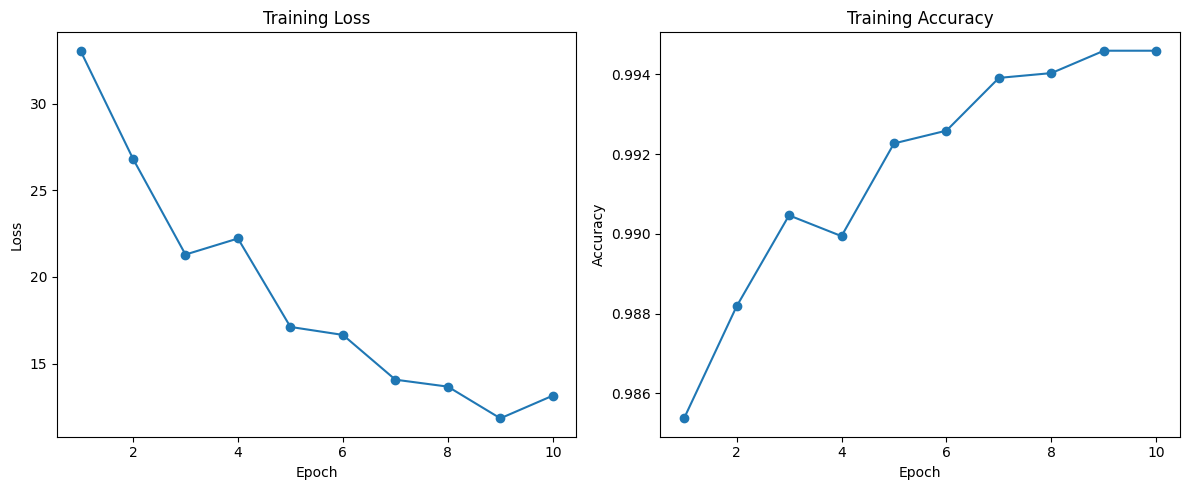

In [ ]:
import matplotlib.pyplot as plt

def plot_history(history):
    """
    Plots training loss and accuracy curves.
    """
    epochs = range(1, len(history["loss"]) + 1)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(epochs, history["loss"], marker='o')
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.subplot(1,2,2)
    plt.plot(epochs, history["accuracy"], marker='o')
    plt.title("Training Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.show()

plot_history(history)


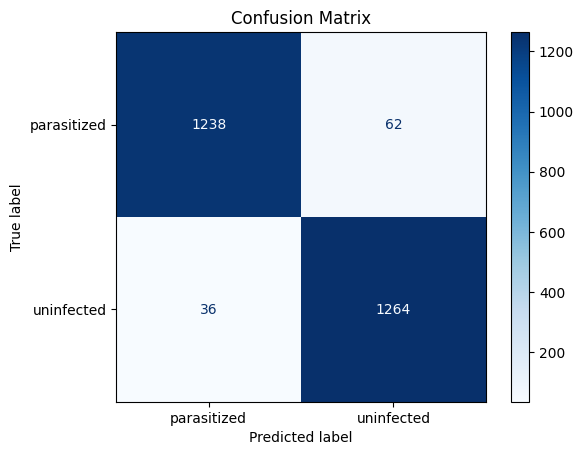

Classification Report:
              precision    recall  f1-score   support

 parasitized       0.97      0.95      0.96      1300
  uninfected       0.95      0.97      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

def show_confusion_matrix(model, dataloader, class_names):
    """
    Plots the confusion matrix for the test set predictions.
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.show()
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

class_names = train_dataset.classes
show_confusion_matrix(model, test_loader, class_names)


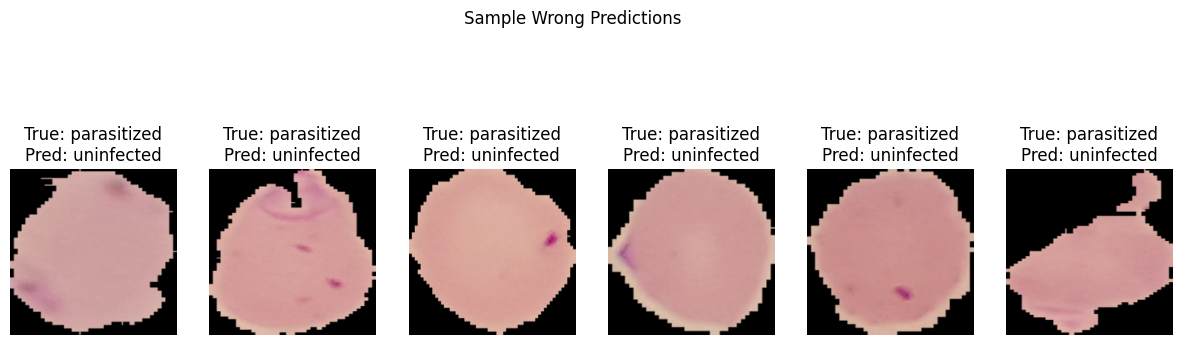

In [ ]:
def plot_wrong_predictions(model, dataloader, class_names, max_samples=6):
    """
    Displays a few misclassified test images.
    """
    model.eval()
    wrong_images, wrong_preds, wrong_labels = [], [], []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            for img, pred, label in zip(images, preds, labels):
                if pred != label:
                    wrong_images.append(img.cpu())
                    wrong_preds.append(pred.cpu())
                    wrong_labels.append(label.cpu())
                if len(wrong_images) >= max_samples:
                    break
            if len(wrong_images) >= max_samples:
                break

    plt.figure(figsize=(15, 5))
    for idx in range(len(wrong_images)):
        img = wrong_images[idx].permute(1, 2, 0) * 0.5 + 0.5  # unnormalize
        plt.subplot(1, max_samples, idx+1)
        plt.imshow(img)
        plt.title(f"True: {class_names[wrong_labels[idx]]}\nPred: {class_names[wrong_preds[idx]]}")
        plt.axis('off')
    plt.suptitle("Sample Wrong Predictions")
    plt.show()

plot_wrong_predictions(model, test_loader, class_names)


In [ ]:
torch.save(model.state_dict(), "vit_malaria.pth")

from google.colab import files
files.download("vit_malaria.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(model, "vit_malaria_full.pt")

files.download("vit_malaria_full.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## 6. Summary Report
Hardware: Google Colab Pro with Tesla T4 GPU
Memory: ~16 GB RAM, GPU Memory ~15 GB VRAM used

## 7. Next Steps
- Add data augmentation
- Try larger ViT model (e.g., vit_base_patch16_224)
- Use model ensembling

## 8. Lessons Learned
- Vision Transformers can achieve strong results on medical image classification
- Using timm simplifies fine-tuning with pretrained models

## 9. Contributions
-  Dataset cleaning and EDA
-  Data preprocessing and augmentation
-  Model selection and fine-tuning
-  Training loop & monitoring
-  Evaluation & visualization
-  Report writing and summary
-  Presentation slides

## PyTorch+Timm Vision Transformer head-only training code

In [ ]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Setup paths (modify as needed)
data_dir = "/content/cell_images/cell_images/cell_images/"
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Image preprocessing
IMG_SIZE = 224
BATCH_SIZE = 32
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

train_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

import timm
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

def get_vit_feature_extractor(num_classes: int) -> nn.Module:
    """
    Loads a pretrained ViT model, replaces the classifier head, and freezes all backbone parameters.

    Args:
        num_classes (int): Number of output classes for the classifier head.

    Returns:
        nn.Module: Vision Transformer model with frozen backbone and trainable classification head.
    """
    model = timm.create_model('vit_tiny_patch16_224', pretrained=True)
    model.head = nn.Linear(model.head.in_features, num_classes)
    # Freeze all backbone parameters except for the final head
    for param in model.parameters():
        param.requires_grad = False
    for param in model.head.parameters():
        param.requires_grad = True
    return model

# Instantiate the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_vit_feature_extractor(num_classes=2).to(device)

import torch.optim as optim
from tqdm import tqdm

def train_head_only(model: nn.Module, train_loader: DataLoader, num_epochs: int = 5) -> None:
    """
    Trains only the classification head of the ViT model. The backbone is kept frozen.

    Args:
        model (nn.Module): Vision Transformer model with a trainable head and frozen backbone.
        train_loader (DataLoader): DataLoader for training data.
        num_epochs (int, optional): Number of training epochs. Default is 5.

    Returns:
        None
    """
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.head.parameters(), lr=1e-3)  # Larger LR for head-only training

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
        acc = correct / len(train_loader.dataset)
        print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}, Accuracy: {acc:.4f}")

# Train only the head
train_head_only(model, train_loader, num_epochs=5)

def evaluate_model(model: nn.Module, test_loader: DataLoader) -> float:
    """
    Evaluates the trained model on the test set.

    Args:
        model (nn.Module): Trained Vision Transformer model.
        test_loader (DataLoader): DataLoader for test data.

    Returns:
        float: Test accuracy.
    """
    model.eval()
    correct = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
    acc = correct / len(test_loader.dataset)
    print(f"Test Accuracy: {acc:.4f}")
    return acc

# Evaluate the model
evaluate_model(model, test_loader)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

100%|██████████| 780/780 [01:46<00:00,  7.34it/s]


Epoch 1, Loss: 127.3125, Accuracy: 0.9429


100%|██████████| 780/780 [01:35<00:00,  8.20it/s]


Epoch 2, Loss: 98.6866, Accuracy: 0.9562


100%|██████████| 780/780 [01:37<00:00,  7.99it/s]


Epoch 3, Loss: 95.8565, Accuracy: 0.9570


100%|██████████| 780/780 [01:34<00:00,  8.23it/s]


Epoch 4, Loss: 93.7954, Accuracy: 0.9575


100%|██████████| 780/780 [01:37<00:00,  8.03it/s]


Epoch 5, Loss: 94.5900, Accuracy: 0.9576
Test Accuracy: 0.9565


0.9565384615384616

In [ ]:
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 192, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=192, out_features=576, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (norm): Identity()
        (proj): Linear(in_features=192, out_features=192, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((192,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=192, out_features=768, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)


In [ ]:
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")


Total parameters: 5,524,802
Trainable parameters: 386


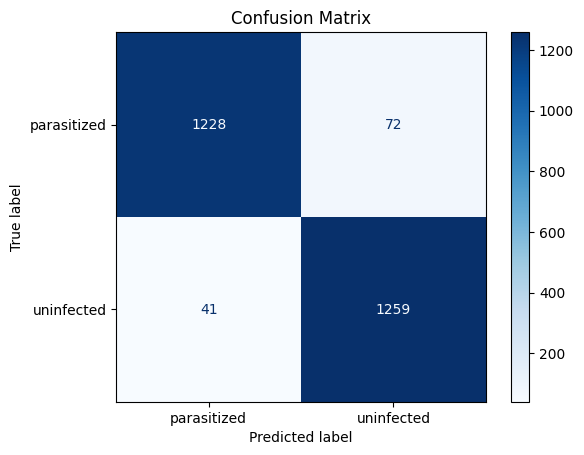

Classification Report:
              precision    recall  f1-score   support

 parasitized       0.97      0.94      0.96      1300
  uninfected       0.95      0.97      0.96      1300

    accuracy                           0.96      2600
   macro avg       0.96      0.96      0.96      2600
weighted avg       0.96      0.96      0.96      2600



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def show_confusion_matrix(model, dataloader, class_names):
    """
    Plots the confusion matrix for the test set predictions.
    Args:
        model: Trained model.
        dataloader: DataLoader for test data.
        class_names: List of class label names.
    """
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix")
    plt.show()
    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names))

class_names = train_dataset.classes

show_confusion_matrix(model, test_loader, class_names)


In [ ]:
torch.save(model.state_dict(), "vit_head-only-training_malaria.pth")

from google.colab import files
files.download("vit_head-only-training_malaria.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
torch.save(model, "vit_head-only-training_malaria.pt")

files.download("vit_head-only-training_malaria.pt")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>